# Week 13 Exercise - Transformers

In this notebook, we will explore the creation of a Transformer Network for English to French translation.  Note that **Transformers are resource intensive and hard to train.** You will want to run these notebooks on a machine equipped with a GPU or on [Google Colab](http://colab.research.google.com).

To begin, let's import a corpus of paired English and French text.  Additionally, we'll tokenize the words (i.e. create a dictionary for each vocabulary associating every word with an integer index).  There is no need to modify this cell, but have a look at what is contained in fr_to_ix (for example) and in enlines.  

In [142]:
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu" 

with open('./french.txt', encoding="utf-8") as file:
    frvocab = file.read().lower()
    frvocab = ''.join([i if ord(i) < 128 else ' ' for i in frvocab])
    frlines = frvocab.split('\n')
frlines = [re.sub(r'[^\w\s\']','',i).split() for i in frlines]
frvocab = set(re.sub(r'[^\w\s\']','',frvocab).replace('\n',' ').split(' '))

with open('./english.txt', encoding="utf-8") as file:
    envocab = file.read().lower()
    envocab = ''.join([i if ord(i) < 128 else '' for i in envocab])
    enlines = envocab.split('\n')
enlines = [re.sub(r'[^\w\s]','',i).split() for i in enlines]
envocab = set(re.sub(r'[^\w\s]','',envocab).replace('\n',' ').strip().split(' '))
envocab.add('<pad>')
envocab.add('<start>')
envocab.add('<eos>')
frvocab.add('<pad>')
frvocab.add('<start>')
frvocab.add('<eos>')
fr_to_ix = {word: i for i, word in enumerate(frvocab)}
en_to_ix = {word: i for i, word in enumerate(envocab)}
ix_to_fr = {fr_to_ix[word]:word for word in frvocab}
ix_to_en = {en_to_ix[word]:word for word in envocab}
enmax = 0
frmax = 16

for i,w in enumerate(enlines):
    temp = len(w)
    if temp > enmax:
        enmax = temp

for i,w in enumerate(frlines):
    temp = len(w)
    if temp > frmax:
        frmax = temp

Next we'll create a handful of helper functions that do things like
 - Tokenize an english string, run it through the transformer producing predictions, then convert back to a french string
 - Compare predicted and target output
 - Mask a string
 - Load paired english/french sequences

In [143]:
def translate(sentence):
    # Read in an english string
    line = re.sub(r'[^\w\s]','',sentence).split()
    # tokenize/pad for consistent sequence length
    line = F.pad(torch.tensor([en_to_ix[w.lower()] for w in line]),(0,enmax-len(line)),value = en_to_ix['<pad>']).unsqueeze(0).to(device)
    # Create an array to hold the French sentence
    target = torch.Tensor(1,frmax-1)
    target = target.new_full((1,frmax-1),fr_to_ix['<pad>']).long().to(device)
    # Start sentence with a <start> character
    target[0,0] = fr_to_ix['<start>']
    
    src,trg = mask(line,target)
    encoding = model.encode(line,src)
    K,V = model.create_dec_KV(encoding)
    for i in range(1,frmax-1):
        test2 = model.decode(target,K,V,src,trg)
        lastout = test2[0,i-1].argmax()
        if lastout.item() == fr_to_ix['<eos>']:
            break
        target[0,i] = lastout
        src,trg = mask(line,target)
    translation = test2.argmax(2).squeeze(0)
    translation_string = ''
    for w in translation:
        if ix_to_fr[w.item()] == '<eos>':
            break
        translation_string += ix_to_fr[w.item()] + ' '
    return translation_string.strip()

def compareoutput(preds,targetlist,loc=None):
    # Compare model predictions with true translation
    if loc is None:
        loc = np.random.randint(len(preds))
    predstr = ''
    labelstr = ''
    for i in range(len(preds[loc][0])):
        if ix_to_fr[targetlist[loc][i+1].item()] == '<eos>':
            break
        predstr += ' '+ ix_to_fr[preds[loc][0][i].item()]
        labelstr += ' ' + ix_to_fr[targetlist[loc][i+1].item()]
    print("\tOutput:", predstr)
    print("\tTarget:",labelstr)
    
class PositionalEncoder(nn.Module):
    # Create a positional encoding generator
    def __init__(self, d_model, max_seq_len = 58):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
            for i in range(1,d_model,2):
                pe[pos, i] = \
                math.cos(pos / (10000 ** ((2 * i)/d_model)))
                
        pe = pe
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:seq_len], \
        requires_grad=False).to(device)
        return x

def mask(input_seq,target_seq):
    input_msk = (input_seq != en_to_ix['<pad>']).unsqueeze(1)
    target_msk = (target_seq != fr_to_ix['<pad>']).unsqueeze(1)
    size = target_seq.size(1) # get seq_len for matrix
    nopeak_mask = np.triu(np.ones((1, size, size)),k=1)
    nopeak_mask = Variable(torch.from_numpy(nopeak_mask).to(device) == 0)
    target_msk = target_msk & nopeak_mask
    return input_msk,target_msk

class custdata(Dataset):
    # Create a custom dataset object to serve up paired english and french lines
    def __init__(self,enlines,frlines):
        self.data_len = len(enlines) 
        self.data = [F.pad(torch.tensor([en_to_ix[w] for w in line]),(0,enmax-len(line)),value = en_to_ix['<pad>']).to(device) for line in enlines]
        self.labels = []
        for line in frlines:
            line = ['<start>',*line,'<eos>']
            self.labels.append(F.pad(torch.tensor([fr_to_ix[w] for w in line]),(0,frmax-len(line)),value = fr_to_ix['<pad>']).to(device))
    
    def __getitem__(self, i):
        return self.data[i],self.labels[i]

    def __len__(self):
        return self.data_len

# Attention
The first task is to code a self-attention mechanism, which corresponds to implementing Eq. 1 in Vaswani.
#### http://jalammar.github.io/illustrated-transformer/ is a great reference for most of the programming in this notebook

In [144]:
class self_attention(nn.Module):
    
    def __init__(self, dim, enc_dim, dropout=.1):
        super().__init__()
        self.wq = nn.Linear(dim, enc_dim) #### TODO#### WEIGHTS FOR Q, INPUT DIM = DIM, OUTPUT DIM = ENC_DIM
        self.wk = nn.Linear(dim, enc_dim) #### TODO#### WEIGHTS FOR K, INPUT DIM = DIM, OUTPUT DIM = ENC_DIM
        self.wv = nn.Linear(dim, enc_dim) #### TODO#### WEIGHTS FOR V, INPUT DIM = DIM, OUTPUT DIM = ENC_DIM
        self.dropout = nn.Dropout(dropout)
        
        self.scaler = np.sqrt(enc_dim)
    
    def QKV(self,x):
        Q = self.wq(x)  #### TODO#### CALCULATE Q
        K = self.wk(x)  #### TODO#### CALCULATE K
        V = self.wv(x)  #### TODO#### CALCULATE V
        return Q, K, V
    
    def score(self,Q,K,V,mask):
        # scores are the stuff that goes inside the softmax
        scores = Q@K.T.permute(2,0,1) / self.scaler ### TODO ### CALCULATE THE SCORES. !!!DONT TOUCH THE PERMUTE!!!
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        scores = self.dropout(F.softmax(scores,-1)) 
        return scores@V ### TODO ### FINISH CALCULATING SELF ATTENTION
    
    def forward(self,x,mask=None):
        Q,K,V = self.QKV(x)
        return self.score(Q,K,V,mask)
   

Next, we need to produce the "special" attention mechanism that takes keys and values from the encoder, but queries from the decoder.  This is very similar to the self-attention mechanism, except that there should be two inputs.  

In [145]:
class encdec_attention(nn.Module):
    def __init__(self, dim, dropout = .1):
        super().__init__()
        self.wq = nn.Linear(dim, dim) #### TODO #### SAME AS ABOVE
        self.wk = nn.Linear(dim, dim) #### TODO #### SAME AS ABOVE
        self.wv = nn.Linear(dim, dim) #### TODO #### SAME AS ABOVE
        self.scaler = np.sqrt(dim)
        self.dropout = nn.Dropout(dropout)
        
    def Q(self,x):
        return self.wq(x)
    
    def score(self,Q,K,V,mask):
        scores = Q@K.T.permute(2,0,1) / self.scaler #### TODO #### SAME AS ABOVE
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        scores = self.dropout(F.softmax(scores,-1)) 
        return scores@V  #### TODO #### SAME AS ABOVE
    
    def forward(self,x,K,V,mask):
        # DB Note: I'm not sure that this signature is right.  Seems like we should be taking x from the
        # decoder, as well as another argument (call it y?) from the encoder, then producing K,V,Q internally,
        # just like in the self-attention scheme.  Otherwise, how are wk and wv being used here?  it looks like 
        # these parameters have been shifted over to the Transformer module's create_dec_KV method.
        Q = self.Q(x)
        out = self.score(Q,K,V,mask)
        return out

# Encoder and Decoder
With the attention mechanisms coded, now we need to create encoder and decoder models. These correspond to the things inside the boxes in Figure 1 of Vaswani.  
#### Fill in the forward passes of the encoder and decoder

In [146]:
class encoder(nn.Module):
    def __init__(self,dim,enc_dim,vocab_size,dropout=.1):
        super().__init__()
        self.dim = dim
        self.enc_dim = enc_dim
        self.residual = nn.Linear(dim, enc_dim)
        
        self.attention = self_attention(dim, enc_dim, dropout)
        self.norm1 = nn.LayerNorm(enc_dim)
        self.linear = nn.Sequential(
            nn.Linear(enc_dim,enc_dim),
            nn.ReLU()
        )
        self.norm2 = nn.LayerNorm(enc_dim)
    
    def forward(self, x, mask):  #### TODO #### SET UP FORWARD PASS OF ENCODER
        x1 = self.attention(x, mask)
        if self.dim != self.enc_dim: ### DONT TOUCH, THIS IS TO HELP WITH THE RESIDUAL CONNECTION ###
            x = self.residual(x)
        x = self.norm1(x + x1)
        x = self.linear(x) + x
        x = self.norm2(x)
        return x
     
        
class decoder(nn.Module):
    
    def __init__(self,dim,input_size,vocab_size,dropout=.1):
        super().__init__()
        self.attention = self_attention(input_size, dim, dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.EDattention = encdec_attention(dim, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.linear = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU()
        )
        self.norm3 = nn.LayerNorm(dim)
    
    def forward(self,x, k, v, enc_mask, dec_mask):#### TODO #### SET UP FORWARD PASS OF DECODER
        x = self.attention(x, dec_mask) + x
        x = self.norm1(x)
        x = self.EDattention(x, k, v, enc_mask) + x
        x = self.norm2(x)
        x = self.linear(x)
        return self.norm3(x)
    

# Transformer

Build the transformer itself by hooking together encoders and decoders.  Note the word embedding layers that we are going to learn.  

#### Add encoders and decoders to transformer

In [147]:
class transformer(nn.Module):
    def __init__(self,dim,encoder_dim,enc_vocab_size,dec_vocab_size,input_size):
        super().__init__()
        self.embedding1 = nn.Embedding(enc_vocab_size, dim)
        self.embedding2 = nn.Embedding(dec_vocab_size, encoder_dim)
        
        self.pe1 = PositionalEncoder(dim, enmax)
        self.pe2 = PositionalEncoder(encoder_dim,frmax)
        self.encoders = []
    
        self.encoders.append(encoder(dim, encoder_dim ,enc_vocab_size)) 
        #### TODO #### ADD DESIRED # OF ENCODERS TO SELF.ENCODERS
        
        
        self.encoders = nn.ModuleList(self.encoders)
        
        self.decoders = []
        
        
        self.decoders.append(decoder(encoder_dim, encoder_dim, dec_vocab_size)) 
        #### TODO #### ADD DESIRED # OF DECODERS TO SELF.DECODERS

       
        self.decoders = nn.ModuleList(self.decoders)
        
        self.final = nn.Sequential(
            nn.Linear(encoder_dim, dec_vocab_size),
            nn.LogSoftmax(2)
        )
        
        self.k = nn.Linear(encoder_dim, encoder_dim)
        self.v = nn.Linear(encoder_dim, encoder_dim)
        
    def create_dec_KV(self,z):
        K = self.k(z)
        V = self.v(z)
        return K,V
    
    def encode(self,x,src):
        x = self.embedding1(x)
        x = self.pe1(x)
        for layer in self.encoders:
            x = layer(x,src)
        return x
    
    def decode(self,y,K,V,src,trg):
        y = self.embedding2(y)
        y = self.pe2(y)
        for layer in self.decoders:
            y = layer(y,K,V,src,trg)
        return self.final(y)
    
    def forward(self,x,y,src,trg):
        
        x = self.encode(x,src)
        K,V = self.create_dec_KV(x)
        y = self.decode(y,K,V,src,trg)
        return y

# Train the network.

##### This will be slow to train and require a lot of resources. You can reduce the batch_size to lower the vram requirement, you can reduce 
##### the run time by lowering number_of_lines

In [148]:
model = transformer(enmax,enmax,len(envocab),len(frvocab),frmax)
model = model.to(device)

In [149]:
optimizer = optim.Adam(model.parameters(), lr=0.01,weight_decay=.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=.1,patience=10,threshold=1,min_lr=.0001)
criterion = nn.NLLLoss()

In [150]:
BATCH_SIZE = 128
NUMBER_OF_LINES = 20000

train = custdata(enlines[:NUMBER_OF_LINES],frlines[:NUMBER_OF_LINES])
trainloader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)
val = custdata(enlines[NUMBER_OF_LINES:NUMBER_OF_LINES+1000],frlines[NUMBER_OF_LINES:NUMBER_OF_LINES+1000])
valloader = torch.utils.data.DataLoader(dataset=val, batch_size=1, shuffle=True, drop_last=False)
test = custdata(enlines[NUMBER_OF_LINES+1000:NUMBER_OF_LINES+2000],frlines[NUMBER_OF_LINES+1000:NUMBER_OF_LINES+2000])
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=1, shuffle=False, drop_last=False)

In [151]:
for i in range(50):
    model.train()
    total_loss = 0
    for j,(context, target) in enumerate(trainloader):
        trg_input = target[:,:-1]
        outmask = target[:,1:]!= fr_to_ix['<pad>']
        targets = target[:,1:].contiguous().view(-1)
        src,trg = mask(context,trg_input)
        output = model(context,trg_input,src,trg)
        optimizer.zero_grad()
        loss = criterion(output.view(output.shape[0]*output.shape[1],-1),targets)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    scheduler.step(total_loss)
    print('Epoch:', i+1,' loss:', total_loss)
    model.eval()
    scores = []
    preds = []
    targetlist = []
    for j,(context, target) in enumerate(valloader):
            trg_input = target[:,:-1]
            targets = target.contiguous().view(-1)
            targetlist.append(targets)
            src,trg = mask(context,trg_input)
            output = model(context,trg_input,src,trg)
            pred = F.softmax(output,2).argmax(2)
            preds.append(pred)
            break
    compareoutput(preds,targetlist,loc=0)

Epoch: 1  loss: 129.60840716958046
	Output:  vous <eos> <eos>
	Target:  cela t'atil amus
Epoch: 2  loss: 55.06452918052673
	Output:  ne m'a <eos> <eos> r
	Target:  ne dis rien mon pouse
Epoch: 3  loss: 45.16173213720322
	Output:  tesvous en <eos>
	Target:  tesvous int ress
Epoch: 4  loss: 38.06944461166859
	Output:  je en le faire
	Target:  suisje dans le vrai
Epoch: 5  loss: 32.89907370507717
	Output:  pourquoi a demand
	Target:  pourquoi l'aije fait
Epoch: 6  loss: 29.609192833304405
	Output:  tu tes nuit s
	Target:  vous tes cern s
Epoch: 7  loss: 27.39999333024025
	Output:  il n'es pas besoin de me
	Target:  tu n'auras pas besoin de moi
Epoch: 8  loss: 25.931726276874542
	Output:  votre visage est ton le
	Target:  ton visage est p le
Epoch: 9  loss: 24.609047532081604
	Output:  vous tes tr s timide
	Target:  vous tes tr s peureuses
Epoch: 10  loss: 23.70317494124174
	Output:  eh <eos> commen train atil ons
	Target:  quoi qu'il en soit commen ons
Epoch: 11  loss: 22.80031880736351
	

# Test your translator

##### Unless you speak french you're going have to check it with google translate https://translate.google.com/
##### I found it started doing alright once the loss got below 10 but this might take a while

In [158]:
sentence = 'i hope to go to the beach'
translate(sentence)

"j'esp re qu'elle est comme ainsi dire la plage"

#### Test it on testing data

Average # of words correct 0.5891164862914863


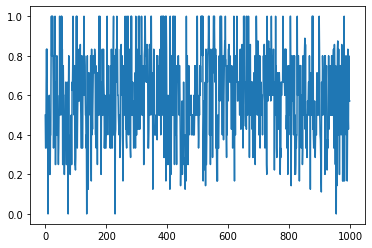

In [159]:
model.eval()
scores = []
preds = []
targetlist = []
for j,(context, target) in enumerate(testloader):
        trg_input = target[:,:-1]
        targets = target[:,1:].contiguous().view(-1)
        targetlist.append(targets)
        src,trg = mask(context,trg_input)
        output = model(context,trg_input,src,trg)
        pred = F.softmax(output,2).argmax(2)
        preds.append(pred)
        correct = sum(pred[0][targets!=fr_to_ix['<pad>']]==targets[targets!=fr_to_ix['<pad>']]).item()/len(targets[targets!=fr_to_ix['<pad>']])
        scores.append(correct)
plt.plot(scores)
print('Average # of words correct',np.mean(scores))

# MULTI-HEAD ATTENTION (Optional)

In [ ]:
class multi_attention(nn.Module):
    def __init__(self,dim,encoder_dim,dropout = .1):
        super().__init__()
        
        heads = []
        for i in range(???): ### TODO ### CHOOSE THE # OF HEADS YOU WANT
            heads.append(???) ### TODO ### ADD SELF_ATTENTION LAYERS TO HEADS
        
        self.heads = nn.ModuleList(heads)
        
        self.linear = nn.Linear(???,encoder_dim) ### TODO ###
    
    
    def forward(self,x,mask=None):
        headoutputs = [layer(x,mask) for layer in self.heads]
        headoutputs = torch.cat(headoutputs,dim=2)
        return self.linear(headoutputs)
    
class encoder(nn.Module):
    def __init__(self,dim,enc_dim,vocab_size,dropout=.1):
        super().__init__()
        self.dim = dim
        self.enc_dim = enc_dim
        self.attention = multi_attention(dim,enc_dim,dropout)
        self.norm1 = nn.LayerNorm(enc_dim)
        self.linear = nn.Sequential(
            nn.Linear(enc_dim,enc_dim),
            nn.ReLU()
        )
        self.residual = nn.Linear(dim,enc_dim)
        self.norm2 = nn.LayerNorm(enc_dim)
    
    def forward(self,x,mask):
        z = self.attention(x,mask)
        if self.dim != self.enc_dim:
            x = self.residual(x)
        z = self.norm1(x+z)
        z2 = self.linear(z)
        return self.norm2(z+z2)
     
    
class decoder(nn.Module):
    def __init__(self,dim,input_size,vocab_size,dropout=.1):
        super().__init__()
        self.attention = multi_attention(input_size,dim,dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.EDattention = encdec_attention(dim,dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.linear = nn.Sequential(
            nn.Linear(dim,dim),
            nn.ReLU()
        )
        self.norm3 = nn.LayerNorm(dim)
    
    def forward(self,x,k,v,src,trg):
        z = self.attention(x,trg)
        z = self.norm1(z+x)
        z2 = self.EDattention(z,k,v,src)
        z2 = self.norm2(z2+z)
        z3 = self.linear(z2)
        return self.norm3(z3+z2)
    
class transformer(nn.Module):
    def __init__(self,dim,encoder_dim,enc_vocab_size,dec_vocab_size,input_size):
        super().__init__()
        self.embedding1 = nn.Embedding(enc_vocab_size,dim)
        self.embedding2 = nn.Embedding(dec_vocab_size,encoder_dim)
        
        self.pe1 = PositionalEncoder(dim,enmax)
        self.pe2 = PositionalEncoder(encoder_dim,frmax)
        self.encoders = []
    
        self.encoders.append(encoder(dim,encoder_dim,enc_vocab_size))   ### FEEL FREE TO ADD OR REMOVE ENCODERS
        self.encoders = nn.ModuleList(self.encoders)
        
        self.decoders = []
        self.decoders.append(decoder(encoder_dim,encoder_dim,dec_vocab_size)) ### FEEL FREE TO ADD OR REMOVE ENCODERS
        self.decoders = nn.ModuleList(self.decoders)
        
        self.final = nn.Sequential(
            nn.Linear(encoder_dim,dec_vocab_size),
            nn.LogSoftmax(2)
        )
        
        self.k = nn.Linear(encoder_dim,encoder_dim)
        self.v = nn.Linear(encoder_dim,encoder_dim)
        
    def create_dec_KV(self,z):
        K = self.k(z)
        V = self.v(z)
        return K,V
    
    def encode(self,x,src):
        x = self.embedding1(x)
        x = self.pe1(x)
        for layer in self.encoders:
            x = layer(x,src)
        return x
    
    def decode(self,y,K,V,src,trg):
        y = self.embedding2(y)
        y = self.pe2(y)
        for layer in self.decoders:
            y = layer(y,K,V,src,trg)
        return self.final(y)
        
    
    def forward(self,x,y,src,trg):
        x = self.encode(x,src)
        K,V = self.create_dec_KV(x)
        y = self.decode(y,K,V,src,trg)
        
        return y



In [ ]:
model = transformer(enmax,enmax,len(envocab),len(frvocab),frmax)
model = model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01,weight_decay=.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=.1,patience=10,threshold=1,min_lr=.0001)
criterion = nn.NLLLoss()

In [ ]:
for i in range(50):
    model.train()
    total_loss = 0
    for j,(context, target) in enumerate(trainloader):
        trg_input = target[:,:-1]
        outmask = target[:,1:]!= fr_to_ix['<pad>']
        targets = target[:,1:].contiguous().view(-1)
        src,trg = mask(context,trg_input)
        output = model(context,trg_input,src,trg)
        optimizer.zero_grad()
        loss = criterion(output.view(output.shape[0]*output.shape[1],-1),targets)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    scheduler.step(total_loss)
    print('Epoch:', i+1,' loss:', total_loss)
    model.eval()
    scores = []
    preds = []
    targetlist = []
    for j,(context, target) in enumerate(valloader):
            trg_input = target[:,:-1]
            targets = target.contiguous().view(-1)
            targetlist.append(targets)
            src,trg = mask(context,trg_input)
            output = model(context,trg_input,src,trg)
            pred = F.softmax(output,2).argmax(2)
            preds.append(pred)
            break
    compareoutput(preds,targetlist,loc=0)

# Test your  multi-head transformer

In [ ]:
sentence = 'how are you'
translate(sentence)

# QUESTION

#### 1) Was the runtime of your multi-head transformer noticably longer than the single head one? What about the speed the loss decreased? If you had the time and resources to train it to a good spot, how did the translation quality compare to the single-headed transformer?

#### 2)Try adding encoders and decoders to one of your transformers. Does having the extra layers improve performance? How does it affect runtime?